# DS 450 HW 3: Use PySpark Machine Learning to Predict Tip Amounts

----
## Setup and configuration

#### See `ds_450_hw2_larson_spark_setup.txt` for:
#### 1. gcloud commands to to create cluster and establish SSH tunnel
#### 2. terminal commands to open browser and connect via SOCKS proxy

##### Note: to look at contents of root folder with command line, must first execute: sudo su

In [2]:
whos

Variable        Type        Data/Info
-------------------------------------
trim_timezone   function    <function trim_timezone at 0x7f5f8c87b8c0>


In [3]:
!pwd
!ls -al

/root/notebooks
total 1124
drwxr-xr-x 3 root root   4096 Aug 22 20:51 .
drwx------ 9 root root   4096 Aug 21 22:35 ..
-rw-r--r-- 1 root root 792816 Aug 21 22:33 ds_450_hw_1_larson.ipynb
-rw-r--r-- 1 root root  20106 Aug 21 22:33 ds_450_hw_2_larson_taxi_data.ipynb
-rw-r--r-- 1 root root  39565 Aug 22 20:50 ds_450_hw_3_larson_predict_taxi_tip.ipynb
-rw-r--r-- 1 root root  39565 Aug 22 20:50 ds_450_hw_3_larson_predict_taxi_tip_verbose_2.ipynb
-rw-r--r-- 1 root root 124488 Aug 21 22:33 ds_450_hw_3_larson_predict_taxi_tip_verbose.ipynb
drwxr-xr-x 2 root root   4096 Aug 22 20:51 .ipynb_checkpoints
-rw-r--r-- 1 root root 111661 Aug 21 22:33 pyspark-taxi.ipynb



#### Install necessary google cloud tools

In [ ]:
!pip install google-compute-engine

#### Install python dependencies

Note: it's possibly to customize the initialization script to install dependencies automatically.
    

In [ ]:
!pip install pandas numpy matplotlib seaborn

----
## Load Libraries and Housekeeping

In [113]:
import pyspark
from pyspark import ml
# Library for talking to the vector column
from pyspark.ml.linalg import Vectors
# Library for transforming columns into vector columns
from pyspark.ml.feature import VectorAssembler
# Lots of models available, can find an equivalent for almost anything found in sklearn,
# e.g., classification, regression, etc. API is also the same as sklearn so should be
# easy to port things over.
import pyspark.ml.regression
# Library to serialize python functions for use with PySpark data frames
from pyspark.sql.functions import udf
# For getting a bunch of useful functions, including time-based functions
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import RegressionEvaluator
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
%matplotlib inline

In [5]:
# Make Cells show all results
InteractiveShell.ast_node_interactivity = "all"

----
## Load taxi data

### Load data and look at structure

In [6]:
# Specify GCS resource for a single file
storage_url = 'gs://datasci-450-hamburger/taxi/yellow-2015-000000000000.csv'

# Read in the data
taxi_shard = (spark.read
              .format('csv')
              .load(storage_url, header=True, inferSchema=True))

In [7]:
# Show the schema (can then use this to specify the schema for the full dataset)
taxi_shard.printSchema

<bound method DataFrame.printSchema of DataFrame[vendor_id: string, pickup_datetime: string, dropoff_datetime: string, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, rate_code: int, passenger_count: int, trip_distance: double, payment_type: string, fare_amount: double, extra: double, mta_tax: double, imp_surcharge: double, tip_amount: double, tolls_amount: double, total_amount: double, store_and_fwd_flag: string]>

In [8]:
# Specify GCS resource for all files
storage_url_all = 'gs://datasci-450-hamburger/taxi/yellow-2015-*.csv'


# Read in the data using schema based on shard
taxi = (spark.read
        .format('csv')
        .load(storage_url_all, header=True, schema=taxi_shard.schema))

# Look at data structure
taxi.columns

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'rate_code',
 'passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'imp_surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'store_and_fwd_flag']

In [9]:
# Sample full data frame to work with for development
# Lazy Eval makes this appear to go quickly, but length required for
# subsequent count command shows the true computational cost of sampling
taxi_sample = taxi.sample(withReplacement=False, fraction=.0001, seed=777)

In [10]:
taxi.count()
taxi_sample.count()

77106102

7775

In [11]:
whos DataFrame

Variable      Type         Data/Info
------------------------------------
taxi          DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_sample   DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_shard    DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]


----
## Declare functions

### Feature creation

#### Time-related features

In [72]:
# Function to create features from time variables (taken from class example)
def trim_timezone(t):
    # String to show the action taken by the function
    """'2015-03-04 09:10:47 UTC' => '2015-03-04 09:10:47'"""
    # try-except structure used to avoid problems arising from what may be a small fraction of the
    # data that don't fit the pattern 
    try:
        day, time, timezone = t.strip().split()
        return ' '.join([day, time])
    except Exception as e:
        # Return fixed value that can be used for filtering later
        return 'cast_fail'
    
# Convert standard py function into a UDF that Spark can package off
# to each of the workers (runs in py4j on worker nodes).
# --> When is this step necessary? Only when using commands not available in PySpark?
trim_timezone_udf=udf(trim_timezone)

# The pipeline fixes the pickup column, then adds it, then fixes the dropoff column, then adds it.
# Could break thip by replacing the old df after the addition of each column and get the same
# effect (see below)
def with_typed_columns(df):    
    return df.withColumn(
        'pickup',
        trim_timezone_udf('pickup_datetime').cast('timestamp')
    ).withColumn(
        'dropoff',
        trim_timezone_udf('dropoff_datetime').cast('timestamp')
    )

# Extract additional features from type-cast time data
# Note: time format symbols defined by the SimpleDateFormat class are supported
# E == 3-letter day of week; e.g., 'Wed' or 'Tue'
def extract_time_features(df) :
    df = df.withColumn('pickup_weekofyear', weekofyear('pickup')
          ).withColumn('pickup_dayofyear', dayofyear('pickup')
          ).withColumn('pickup_weekday', date_format('pickup', 'E')
          ).withColumn('pickup_daynum', date_format('pickup', 'u')
          ).withColumn('pickup_hour', date_format('pickup', 'k')
          ).withColumn('dropoff_weekofyear', weekofyear('dropoff')
          ).withColumn('dropoff_dayofyear', dayofyear('dropoff')
          ).withColumn('dropoff_weekday', date_format('dropoff', 'E')
          ).withColumn('dropoff_daynum', date_format('dropoff', 'u')
          ).withColumn('dropoff_hour', date_format('dropoff', 'k'),)
    
    # Here time features extracted as strings are being recast as double,
    # and the new column will replace the old one. If the new coulmn should be
    # added with a different name, and the old one preserved, then the first
    # argument in the .withColumn method should contain the new column name
    return df.withColumn('pickup_daynum', df['pickup_daynum'].cast('double')
            ).withColumn('pickup_hour', df['pickup_hour'].cast('double')
            ).withColumn('dropoff_daynum', df['dropoff_daynum'].cast('double')
            ).withColumn('dropoff_hour', df['dropoff_hour'].cast('double'),)

#### Spatial features

In [13]:
# Make a function that discretizes (e.g., bins) numeric data
# NOTE:transforms act like a function insofar as they can be created without input, and used later
#       when an input is supplied
# NOTE: Many useful transforms available with .feature method, and they can be chained
def make_bucketer(input_col, output_col, sample, num_buckets=10):
    # Define the hyperparameters of the the discretizer 
    # --> Why is there a comma following the last argument?
    qd = pyspark.ml.feature.QuantileDiscretizer(
         numBuckets = num_buckets, 
         inputCol = input_col, 
         outputCol = output_col,)
    
    # Use the previously defined dsicretizer to identify the thresholds based on input data
    # NOTE:  bucketer is built for a specific column, and later application requires that this
    #        column be present with matching name when transform is applied
    bucketer = qd.fit(sample)
    
    # Return an object that can be used to bin new data with pre-determined thresholds. 
    return bucketer

# Function to apply previously created and stored transforms to new data. 
def apply_transforms(df, transforms):
    for transform_key, transform_op in transforms.iteritems():
        print 'Applying transform ', transform_key
        # This will add a discretized column to data frame
        df = transform_op.transform(df)
    return df

### Data transformations and model creation and execution

In [14]:
# Function to take data frame and list of columns as as input
# Return transformed data with column of feature vectors and labels 
def transData (df, feature_cols, label_col) :
    # Create the assembler. Features stored as columns will be transformed into a single column
    # of feature vectors
    assembler = VectorAssembler(inputCols = feature_cols, outputCol='features')
    
    # Reduce dataframe to desired features, and the label column.
    # Transform the reduced data frame using the assembler
    df.select(feature_cols + [label_col]).columns
    df_xform = assembler.transform(
        df.select(feature_cols + [label_col])
    )
    
    # Standardize header of label column, reduce data frame to just label and feature vector columns
    # --> Does the model object expect the label and feature vector columns to be in a certain order?
    df_for_model = df_xform.withColumnRenamed(label_col, 'label').select('label', 'features')
    return df_for_model

# Function to create the model object. Takes assembled training data as input, returns a fit to the data
def makeModel (df_for_model) :
    # Create the linear regression model, limit the number of iterations for the training phase 
    lr = pyspark.ml.regression.LinearRegression(maxIter=100000)
    
    # Fit the model to the training data
    # --> Does this assume order of input data frame is label, feature vectors?
    lrmodel = lr.fit(df_for_model)
    return lrmodel

# Function to run through the model pipeline with training data and feature set as inputs
def modelPipeline (df_train, feature_cols, label_col) :
    # Prepare data for modeling
    df_xform = transData(df_train, feature_cols, label_col)
    # Create linear regression model object
    lr_model = makeModel(df_xform)
    return lr_model

## Run the feature creation pipeline

### Split the data

In [15]:
# Want to split the data first because don't want to re-split the data every time new features are tested
taxi_train, taxi_test = taxi.randomSplit([.3, .7])

In [16]:
taxi_train.count()
taxi_test.count()

23141278

53964824

In [18]:
whos DataFrame

Variable      Type         Data/Info
------------------------------------
taxi          DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_sample   DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_shard    DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_test     DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_train    DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]


### Time-related features

In [22]:
# Apply function to type-cast raw date/time data (dependency is trim_timezone)
taxi_typed = with_typed_columns(taxi_train)
taxi_typed.columns
# Show an example
taxi_typed.select('pickup', 'dropoff').show(3)

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'rate_code',
 'passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'imp_surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'store_and_fwd_flag',
 'pickup',
 'dropoff']

+-------------------+-------------------+
|             pickup|            dropoff|
+-------------------+-------------------+
|2015-01-01 00:02:46|2015-01-01 00:04:04|
|2015-01-01 00:02:56|2015-01-01 00:07:44|
|2015-01-01 00:03:16|2015-01-01 00:05:23|
+-------------------+-------------------+
only showing top 3 rows



In [73]:
# Add some additional time features from the type-cast time data
taxi_typed = extract_time_features(taxi_typed)

# Show results
taxi_typed.printSchema
taxi_typed.select('dropoff_weekday', 'dropoff_daynum', 'dropoff_hour').show(3)

<bound method DataFrame.printSchema of DataFrame[vendor_id: string, pickup_datetime: string, dropoff_datetime: string, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, rate_code: int, passenger_count: int, trip_distance: double, payment_type: string, fare_amount: double, extra: double, mta_tax: double, imp_surcharge: double, tip_amount: double, tolls_amount: double, total_amount: double, store_and_fwd_flag: string, pickup: timestamp, dropoff: timestamp, pickup_weekofyear: int, pickup_dayofyear: int, pickup_weekday: string, pickup_daynum: double, pickup_hour: double, dropoff_weekofyear: int, dropoff_dayofyear: int, dropoff_weekday: string, dropoff_daynum: double, dropoff_hour: double]>

+---------------+--------------+------------+
|dropoff_weekday|dropoff_daynum|dropoff_hour|
+---------------+--------------+------------+
|            Thu|           4.0|        24.0|
|            Thu|           4.0|        24.0|
|            Thu|           4.0|        24.0|
+---------------+--------------+------------+
only showing top 3 rows



### Spatial features

In [103]:
# Set up a list of columns for which to create bucketing transforms
geo_features = [
    'pickup_latitude', 'pickup_longitude', 
    'dropoff_latitude', 'dropoff_longitude']

# Specify number of buckets (Run this once with 20 buckets and once with 10 buckets)
NUM_BUCKETS = 20
# Initiate dsicretizer storage variable
geo_bucketers = {}

# Loop over target columns
for geo_f in geo_features:
    # Apply bucketer function to each column, returning a discretizing object
    # NOTE: the '%s_q%d' string specifies the output name for the bucketizer 
    #       based on function inputs
    geo_bucketer = make_bucketer(
        geo_f, '%s_q%d' % (geo_f, NUM_BUCKETS), 
        taxi_sample, 
        num_buckets=NUM_BUCKETS)
    # Store the discretizer in the storage array with column name as key 
    geo_bucketers[geo_f] = geo_bucketer
    
# Verify the array of transforms (in this case, bucketers) was populated
geo_bucketers

{'dropoff_latitude': Bucketizer_42a49699df7da4efdf0e,
 'dropoff_longitude': Bucketizer_49028fa6ad9796382947,
 'pickup_latitude': Bucketizer_46deae9b05649c67e087,
 'pickup_longitude': Bucketizer_49e8af53e0bbcb3ab5a6}

In [27]:
# Apply the series of newly-minted transforms to the data
# NOTE: assumes the input data (first argument) has a column header that 
#       matches the one the bucketer was built for
# NOTE: Assumes creation of geobucketers was re-run with new number of buckets
taxi_typed_geo = apply_transforms(taxi_typed, geo_bucketers)
taxi_typed_geo.columns

Applying transform  dropoff_longitude
Applying transform  pickup_latitude
Applying transform  dropoff_latitude
Applying transform  pickup_longitude


['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'rate_code',
 'passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'imp_surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'store_and_fwd_flag',
 'pickup',
 'dropoff',
 'pickup_weekofyear',
 'pickup_dayofyear',
 'pickup_weekday',
 'pickup_daynum',
 'pickup_hour',
 'dropoff_weekofyear',
 'dropoff_dayofyear',
 'dropoff_weekday',
 'dropoff_daynum',
 'dropoff_hour',
 'dropoff_longitude_q20',
 'pickup_latitude_q20',
 'dropoff_latitude_q20',
 'pickup_longitude_q20']

In [32]:
# Get a pandas data frame for plotting
pdf = taxi_typed_geo.select('dropoff_longitude_q%d' % NUM_BUCKETS,
                            'pickup_latitude_q%d' % NUM_BUCKETS,
                            'dropoff_latitude_q%d' % NUM_BUCKETS,
                            'pickup_longitude_q%d' % NUM_BUCKETS, 
                            'tip_amount').limit(100000).toPandas()

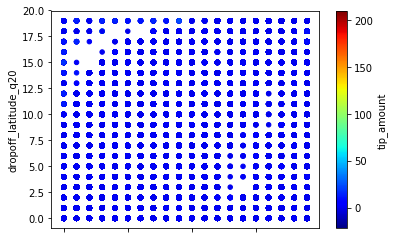

In [33]:
# Plot the data
# Doesn't appear to be much dependence on lat-long with 20 buckets
pdf.plot(kind='scatter', 
         x='dropoff_longitude_q20', y='dropoff_latitude_q20',
         c='tip_amount', colormap='jet')

In [35]:
# Add columns with coarser discretization for lat-long
taxi_typed_geo = apply_transforms(taxi_typed_geo, geo_bucketers)
taxi_typed_geo.columns

Applying transform  dropoff_longitude
Applying transform  pickup_latitude
Applying transform  dropoff_latitude
Applying transform  pickup_longitude


['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'rate_code',
 'passenger_count',
 'trip_distance',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'imp_surcharge',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'store_and_fwd_flag',
 'pickup',
 'dropoff',
 'pickup_weekofyear',
 'pickup_dayofyear',
 'pickup_weekday',
 'pickup_daynum',
 'pickup_hour',
 'dropoff_weekofyear',
 'dropoff_dayofyear',
 'dropoff_weekday',
 'dropoff_daynum',
 'dropoff_hour',
 'dropoff_longitude_q20',
 'pickup_latitude_q20',
 'dropoff_latitude_q20',
 'pickup_longitude_q20',
 'dropoff_longitude_q10',
 'pickup_latitude_q10',
 'dropoff_latitude_q10',
 'pickup_longitude_q10']

In [36]:
# Get a pandas data frame for plotting
pdf = taxi_typed_geo.select('dropoff_longitude_q%d' % NUM_BUCKETS,
                            'pickup_latitude_q%d' % NUM_BUCKETS,
                            'dropoff_latitude_q%d' % NUM_BUCKETS,
                            'pickup_longitude_q%d' % NUM_BUCKETS, 
                            'tip_amount').limit(100000).toPandas()

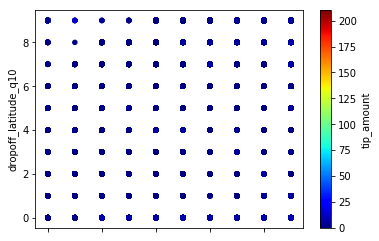

In [37]:
# Plot the data
# pdf.plot(kind='scatter', 
#          x='dropoff_longitude_q10', y='dropoff_latitude_q10',
#          c='tip_amount', colormap='jet')

## Run the model pipeline
#### Go once through manually to verify operation then automate, so new features can be more easily tested

### Transform data for modeling

In [38]:
whos DataFrame

Variable         Type         Data/Info
---------------------------------------
pdf              DataFrame           dropoff_longitude_<...>[100000 rows x 5 columns]
taxi             DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_sample      DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_shard       DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_test        DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_train       DataFrame    DataFrame[vendor_id: stri<...>ore_and_fwd_flag: string]
taxi_typed       DataFrame    DataFrame[vendor_id: stri<...>ng, dropoff_hour: string]
taxi_typed_geo   DataFrame    DataFrame[vendor_id: stri<...>up_longitude_q10: double]


In [39]:
# Create list of columns of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance']
# Specify the column that you're trying to predict
label_col = 'tip_amount'
taxi_xform = transData(taxi_typed_geo, feature_cols, label_col)
taxi_xform.show(5)

+-----+-------------+
|label|     features|
+-----+-------------+
|  4.0|[1.0,2.7,0.2]|
|  0.0|[1.0,5.5,0.9]|
|  0.0|[1.0,3.5,0.4]|
|  2.0|[1.0,7.7,1.8]|
|  0.0|[1.0,2.5,0.0]|
+-----+-------------+
only showing top 5 rows



### Create Model Object

In [40]:
taxi_model = makeModel(taxi_xform)
taxi_model

LinearRegression_4cdfa0ca978deb0ee760

### Evaluate performance

In [42]:
taxi_model.summary.residuals.show(5)
taxi_model.summary.r2

+-------------------+
|          residuals|
+-------------------+
|  2.175627313591211|
|-1.8456954266534162|
| -1.830464897907254|
|0.13755097959244433|
| -1.822849628334161|
+-------------------+
only showing top 5 rows



1.9750778790239565e-07

### Model testing using the model pipeline function

#### Base Model

In [43]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

1.9750778801341795e-07

#### Base Model + tips filtered to exlcude zero's and high outliers

In [80]:
# Filter to 0 < tip amount < 50% of fare amount
taxi_typed_geo_filt = taxi_typed_geo.filter(taxi_typed_geo.tip_amount > 0
                                   ).filter(taxi_typed_geo.tip_amount < 0.5 * taxi_typed_geo.fare_amount)
taxi_typed_geo_filt.count()

13913186

In [82]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

# Got a huge Jump in excluding the zeros and outliers! Use this data from this point on.

0.7756066490761879

#### Base + Fine-grained dropoff spatial features

In [83]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance',
                'dropoff_latitude_q20','dropoff_longitude_q20']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

0.7757275658591434

#### Base + coarse-grained dropoff spatial features

In [84]:
# Specify features of interest
# feature_cols = ['passenger_count', 'fare_amount', 'trip_distance',
#                 'dropoff_latitude_q10','dropoff_longitude_q10']
# # Run the pipeline
# taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# # Calculate the metric
# taxi_model2.summary.r2

0.7757083139125627

#### Base + Fine-grained dropoff time features

In [85]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance','dropoff_hour']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

0.7757870082641606

#### Base + medium-grained dropoff time features

In [86]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance','dropoff_daynum']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

0.7757703991632623

#### Base + coarse-grained dropoff time features

In [87]:
# Specify features of interest
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance','dropoff_weekofyear']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

0.7756268969767282

#### Base + Fine-grained dropoff spatial + time features

In [93]:
# The more highly resolved features appeared to work the best for both space and time
# So combine these here.
feature_cols = ['passenger_count', 'fare_amount', 'trip_distance',
                'dropoff_hour','dropoff_latitude_q20','dropoff_longitude_q20']
# Run the pipeline
taxi_model2 = modelPipeline(taxi_typed_geo_filt, feature_cols, 'tip_amount')
# Calculate the metric
taxi_model2.summary.r2

0.7759129993189513

### Generate Predictions on Test Set
#### Use the previously identified optimal feature set

In [99]:
# Add time features for test data
taxi_typed_test = with_typed_columns(taxi_test)
taxi_typed_test = extract_time_features(taxi_typed_test)

In [104]:
# Add spatial features for the test data
taxi_typed_geo_test = apply_transforms(taxi_typed_test, geo_bucketers)

Applying transform  dropoff_longitude
Applying transform  pickup_latitude
Applying transform  dropoff_latitude
Applying transform  pickup_longitude


In [105]:
# Filter to 0 < tip amount < 50% of fare amount
taxi_typed_geo_filt_test = taxi_typed_geo_test.filter(taxi_typed_geo_test.tip_amount > 0
                                             ).filter(taxi_typed_geo_test.tip_amount < 0.5 * 
                                                      taxi_typed_geo_test.fare_amount)
taxi_typed_geo_filt_test.count()

32439139

In [106]:
# Prepare test data for model application
taxi_xform_test = transData(taxi_typed_geo_filt_test, feature_cols, label_col)
taxi_xform_test.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  3.0|[1.0,24.2,5.4,24....|
|  1.0|[2.0,4.5,0.8,24.0...|
|  3.0|[1.0,13.7,3.3,24....|
| 5.75|[1.0,27.5,8.6,24....|
| 1.25|[1.0,3.7,0.5,24.0...|
+-----+--------------------+
only showing top 5 rows



In [111]:
# Apply model to generate predictions
taxi_pred = taxi_model2.transform(taxi_xform_test)
taxi_pred.show(5)

+-----+--------------------+------------------+
|label|            features|        prediction|
+-----+--------------------+------------------+
|  3.0|[1.0,24.2,5.4,24....| 4.953960307414459|
|  1.0|[2.0,4.5,0.8,24.0...|1.0837531542770331|
|  3.0|[1.0,13.7,3.3,24....| 2.896944597990918|
| 5.75|[1.0,27.5,8.6,24....|5.6231642947996585|
| 1.25|[1.0,3.7,0.5,24.0...|0.9275047780316135|
+-----+--------------------+------------------+
only showing top 5 rows



In [116]:
# Evaluate performance
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator.evaluate(taxi_pred)

0.7797787666514014